In [92]:
# basic imports 
import matplotlib.pyplot as plt 
from pathlib import Path 
from importlib import reload 
import time 

# Notebook imports 
from IPython.display import clear_output

# Learning imports 
import torch 
import gymnasium as gym

# Custom imports 
from RLManager import * 
import MissileEnv

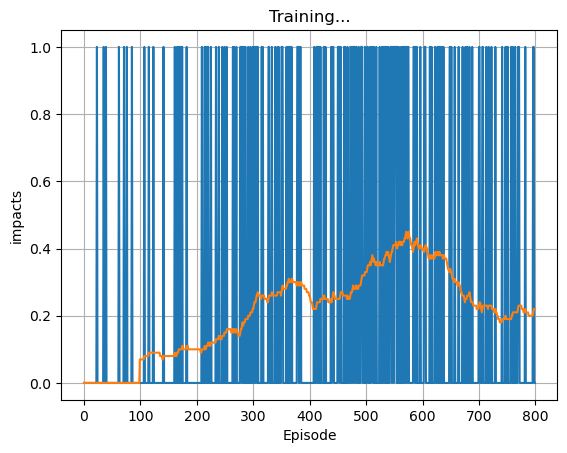

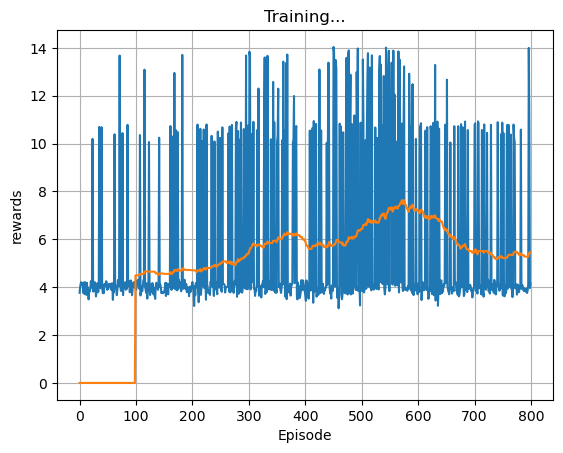

dict_keys(['durations', 'rewards', 'impacts', 'epsilon'])

In [244]:
# Plot training curves 
# def plot_training(path): 

data = Path('Output') / 'ModelStats'
dd = torch.load(data, weights_only=False)
epp = lambda s: episode_plot(dd[s], s)
epp('impacts')
plt.show()
epp('rewards')
# plt.ylim([-1, 3])
plt.show()
# episode_plot(dd

dd.keys()

In [245]:
# Load the model 
save_loc = Path('Output')
model = torch.load(save_loc / 'ModelTorch.pkl', weights_only=False)  # Needs access to DQN class 
# model = torch.load(Path('Archive') / 'CartPole_01' / 'ModelTorch.pkl', weights_only=False)

In [255]:
# Test the model 
reload(MissileEnv)

# Behavior vars 
pause_frames = False 

# env = gym.make("CartPole-v1", render_mode='human')
# name = 'cart' 

env = MissileEnv.MissileEnv()
env.render_mode = 'human'
env.follow_missile = False
env.move_target = True
name = 'missile'

observation, info = env.reset()

# Run the model
frames_per_pause = 15
n = 500
da = (env.action_size-1)/2
actions = []
rewards = []
tx = []
ty = []
mx = []
my = []
obs = observation[np.newaxis, :]
for _ in range(n):
    print(f"Step {_}")
    # action = env.action_space.sample()
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    action = model(state).max(1).indices.view(1, 1)
    actions.append((action.cpu().numpy()[0][0]-da)/da)
    observation,reward, terminated, truncated, info = env.step(action.item())

    # Tracking 
    print(f"obs   : {observation}")
    obs = np.concat((obs, observation[np.newaxis, :]), axis=0)
    rewards.append(reward)
    tx.append(env.target.position.x)
    ty.append(env.target.position.y)
    mx.append(env.missile.position.x)
    my.append(env.missile.position.y)
    
    # Plotting 
    if pause_frames: 
        if (_+1) % frames_per_pause == 0: 
            clear_output()
            plt.plot(actions, '.-')
            plt.plot(obs[:, 4], '.-')
            plt.plot(obs[:, 2], '.-')
            plt.plot(obs[:, 3], '.-')
            plt.plot(rewards, '.-')
            plt.legend(["Action", 'distance', "v_inline", 'v_offline', 'reward'])
            plt.grid()
            plt.show()
        
            x = input("continue?")
            if x == 'quit': 
                break
    
    if terminated or truncated:
        observation, info = env.reset()
        break

Step 0
env action: 1.0
obs   : [-0.91234476 -0.40942282 -0.8486876  -0.52889446  0.88503638]
Step 1
env action: 1.0
obs   : [-0.87368495 -0.48649215 -0.80802105 -0.58915362  0.92795084]
Step 2
env action: 1.0
obs   : [-0.83029156 -0.55732927 -0.76732956 -0.64125295  0.96808211]
Step 3
env action: -0.5
obs   : [-0.86737019 -0.49766349 -0.81214266 -0.58345891  1.        ]
Step 4
env action: 1.0
obs   : [-0.822723   -0.5684425  -0.77451338 -0.63255753  1.        ]
Step 5
env action: -0.5
obs   : [-0.86056051 -0.50934821 -0.82034968 -0.57186222  1.        ]
Step 6
env action: 1.0
obs   : [-0.81489021 -0.57961535 -0.78591316 -0.61833689  1.        ]
Step 7
env action: 1.0
obs   : [-0.76526315 -0.64371758 -0.75202955 -0.65912939  1.        ]
Step 8
env action: -0.5
obs   : [-0.8104274  -0.58583908 -0.80369452 -0.59504211  1.        ]
Step 9
env action: 1.0
obs   : [-0.76042964 -0.64942032 -0.77235561 -0.63519037  1.        ]
Step 10
env action: -0.5
obs   : [-0.80630907 -0.59149445 -0.822603

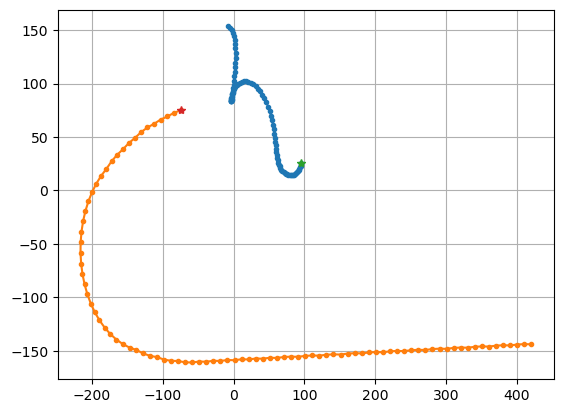

In [256]:
# Plot position over time 
plt.plot(tx, ty, '.-')
plt.plot(mx, my, '.-')
plt.plot(tx[0], ty[0], '*')
plt.plot(mx[0], my[0], '*')
plt.grid()

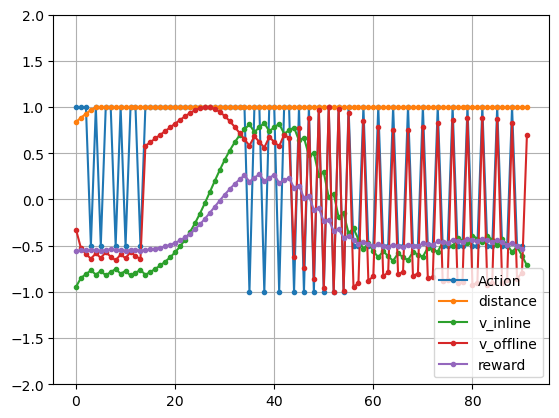

In [257]:
# Plot human readable inputs / outputs
reward_mult = 10
plt.plot(actions, '.-')
plt.plot(obs[:, 4], '.-')
plt.plot(obs[:, 2], '.-')
plt.plot(obs[:, 3], '.-')
plt.plot(np.array(rewards)*reward_mult, '.-')
plt.legend(["Action", 'distance', "v_inline", 'v_offline', 'reward'])
plt.ylim([-2, 2])
plt.grid()

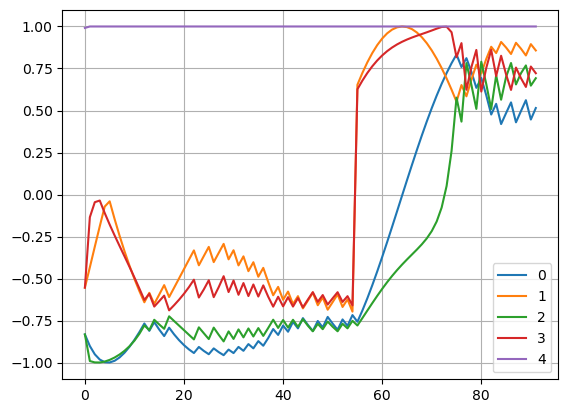

In [254]:
n = 5
plt.figure()
plt.plot(obs[:, 0:n])
plt.legend(list(range(n)))
plt.grid()

In [173]:
np.abs(observation[3])

np.float64(0.18939055053765502)

In [43]:
reward

10